In [43]:
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus
import pandas as pd
from faker import Faker
from datetime import datetime, timedelta
import random
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import nbconvert
import warnings
from IPython.display import Markdown, display
import sys
import os
import logging
import nbformat
import contextlib
from nbconvert import HTMLExporter
from traitlets.config import Config
from bs4 import BeautifulSoup

warnings.filterwarnings("ignore")

# **Analiza bazy danych - załogowe loty kosmiczne Space-U**
#### Projekt w ramach kursu Bazy Danych, MST VI Semestr, czerwiec 2025

In [44]:
username = "team01"
password = quote_plus("te@mloi")  # koduje hasło bezpiecznie
host = "giniewicz.it"
port = 3306
database = "team01"

engine = create_engine(
    f"mysql+pymysql://{username}:{password}@{host}:{port}/{database}"
)

fake = Faker("pl_PL")
today = datetime.today()

### **Najpopularniejsze rodzaje wypraw, ich koszta i zyski oraz czy są opłacalne?**

Naszym celem było porównanie poszczególnych rodzajów wypraw organizowanych przez firmę Space-U pod względem ich popularności, przychodów, kosztów oraz zysków. Kluczowym pytaniem badawczym było ustalenie, które z wypraw są najbardziej popularne wśród klientów i jednocześnie przynoszą firmie realne zyski.

Analizie poddaliśmy dane z czterech tabel: Wyprawy, Rodzaje_Wypraw, Koszty_Operacyjne oraz Rezerwacje. Dane zostały zagregowane na poziomie rodzaju wyprawy, przy czym liczba rezerwacji służyła jako miara popularności, a zysk został obliczony jako różnica między sumarycznym przychodem a kosztem operacyjnym dla danego typu wyprawy.


  Popularność, koszty, zyski:

                              nazwa  rezerwacje    przychod     koszt        zysk
        Księżyc – Przelot Orbitalny          10  15,591,210   541,000  15,050,210
                  Zero-G Experience           9     194,208   374,300    -180,092
               Hotel Orbitalny ISS+           5   2,334,575   405,000   1,929,575
             Mars Orbiter Adventure           5  58,202,250 1,050,000  57,152,250
              Europa Science Cruise           5 189,891,000 2,050,000 187,841,000
        Asteroid Mining Mission S14           4  91,338,000 1,245,000  90,093,000
Księżyc – Lądowanie Tranquillitatis           3  10,330,680   568,600   9,762,080
                    Phobos Explorer           3  49,162,960 1,100,000  48,062,960


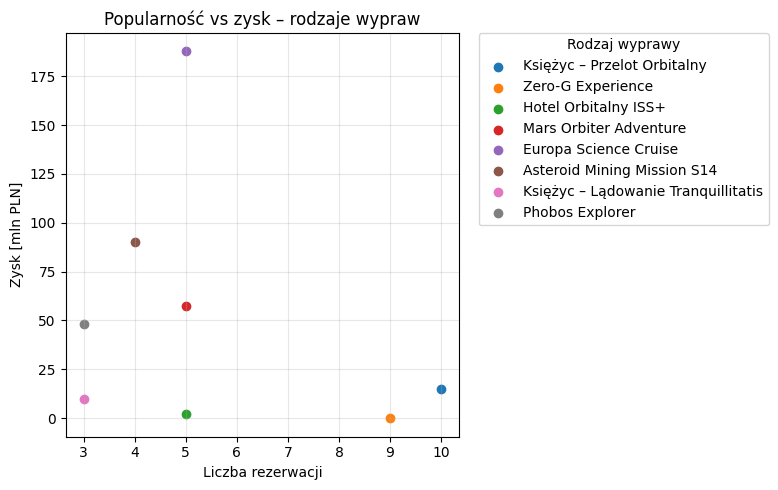

In [45]:
# wczytanie danych
wyprawy = pd.read_sql("SELECT id_wyprawy, id_rodzaju_wyprawy FROM Wyprawy", engine)
rodzaje = pd.read_sql("SELECT id_rodzaju, nazwa FROM Rodzaje_Wypraw", engine)
koszty  = pd.read_sql("SELECT id_wyprawy, kwota FROM Koszty", engine)
rez     = pd.read_sql("SELECT id_wyprawy, cena_koncowa FROM Rezerwacje", engine)

# agregacje
pop  = rez.groupby('id_wyprawy', as_index=False).agg(
          rezerwacje=('id_wyprawy', 'size'),
          przychod   =('cena_koncowa', 'sum'))

cost = koszty.groupby('id_wyprawy', as_index=False).agg(koszt=('kwota', 'sum'))

df = (wyprawy
      .merge(pop,  on='id_wyprawy')
      .merge(cost, on='id_wyprawy', how='left')
      .fillna({'koszt': 0})
      .merge(rodzaje, left_on='id_rodzaju_wyprawy', right_on='id_rodzaju'))

by_type = (df
           .groupby(['id_rodzaju','nazwa'], as_index=False)
           .agg(rezerwacje=('rezerwacje','sum'),
                przychod   =('przychod','sum'),
                koszt      =('koszt','sum')))
by_type['zysk'] = by_type['przychod'] - by_type['koszt']
by_type = by_type.sort_values('rezerwacje', ascending=False)

# czytelny wydruk liczb
fmt = '{:,.0f}'.format
print("\n  Popularność, koszty, zyski:\n")
print(by_type[['nazwa','rezerwacje','przychod','koszt','zysk']]
      .to_string(index=False,
                 formatters={'przychod':fmt, 'koszt':fmt, 'zysk':fmt}))

# scatter-plot 
cmap = plt.colormaps['tab10']
colors = [cmap(i % cmap.N) for i in range(len(by_type))]

fig, ax = plt.subplots(figsize=(8, 5))
for i, row in enumerate(by_type.itertuples()):
    ax.scatter(row.rezerwacje, row.zysk / 1e6,
               color=colors[i], label=row.nazwa)
    
ax.set_xlabel("Liczba rezerwacji")
ax.set_ylabel("Zysk [mln PLN]")
ax.set_title("Popularność vs zysk – rodzaje wypraw")
ax.grid(alpha=0.3)

# legenda obok wykresu
ax.legend(title="Rodzaj wyprawy",
          bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

most_popular_row = pd.read_sql("""
    SELECT r.nazwa, COUNT(*) AS liczba_rezerwacji
    FROM Rezerwacje rez
    JOIN Wyprawy w ON rez.id_wyprawy = w.id_wyprawy
    JOIN Rodzaje_Wypraw r ON w.id_rodzaju_wyprawy = r.id_rodzaju
    GROUP BY r.id_rodzaju, r.nazwa
    ORDER BY liczba_rezerwacji DESC
    LIMIT 1;
""", engine)

most_popular = most_popular_row['nazwa'].iloc[0]

no_profit_row = pd.read_sql("""
    SELECT r.nazwa,
           SUM(rez.cena_koncowa) AS przychod,
           IFNULL(SUM(k.kwota), 0) AS koszt,
           SUM(rez.cena_koncowa) - IFNULL(SUM(k.kwota), 0) AS zysk
    FROM Rezerwacje rez
    JOIN Wyprawy w ON rez.id_wyprawy = w.id_wyprawy
    JOIN Rodzaje_Wypraw r ON w.id_rodzaju_wyprawy = r.id_rodzaju
    LEFT JOIN Koszty k ON w.id_wyprawy = k.id_wyprawy
    GROUP BY r.id_rodzaju, r.nazwa
    ORDER BY zysk ASC
    LIMIT 1;
""", engine)

no_profit = no_profit_row['nazwa'].iloc[0]

max_profit_row = pd.read_sql("""
    SELECT r.nazwa,
           SUM(rez.cena_koncowa) AS przychod,
           IFNULL(SUM(k.kwota), 0) AS koszt,
           SUM(rez.cena_koncowa) - IFNULL(SUM(k.kwota), 0) AS zysk
    FROM Rezerwacje rez
    JOIN Wyprawy w ON rez.id_wyprawy = w.id_wyprawy
    JOIN Rodzaje_Wypraw r ON w.id_rodzaju_wyprawy = r.id_rodzaju
    LEFT JOIN Koszty k ON w.id_wyprawy = k.id_wyprawy
    GROUP BY r.id_rodzaju, r.nazwa
    ORDER BY zysk DESC
    LIMIT 1;
""", engine)

max_profit = max_profit_row['nazwa'].iloc[0]


In [46]:
display(Markdown(f"#### Na podstawie przeprowadzonej analizy zidentyfikowano najbardziej popularne i najbardziej opłacalne wyprawy: Najwięcej rezerwacji uzyskała wyprawa **{most_popular}**. Najmnijesze zyski przyniosła wyprawa **{no_profit}**, co może sugerować zbyt niską cenę w stosunku do kosztów organizacji wyprawy. Największe zyski wygenerowała **{max_profit}**."))

#### Na podstawie przeprowadzonej analizy zidentyfikowano najbardziej popularne i najbardziej opłacalne wyprawy: Najwięcej rezerwacji uzyskała wyprawa **Księżyc – Przelot Orbitalny**. Najmnijesze zyski przyniosła wyprawa **Zero-G Experience**, co może sugerować zbyt niską cenę w stosunku do kosztów organizacji wyprawy. Największe zyski wygenerowała **Europa Science Cruise**.

#### Wnioski 
Nie wszystkie popularne wyprawy są opłacalne.
Z perspektywy strategicznej, nasza firma powinna rozważyć:

- Podniesienie ceny usług w przypadku popularnych, lecz nierentownych wypraw,

- Zwiększenie promocji wypraw o wysokiej rentowności,

- Analizę kosztów operacyjnych w celu zwiększenia marży zysku.

### **Wykres liczby obsłużonych klientów w każdym miesiącu działalności firmy, czy firma rośnie, czy podupada?**

Celem tej analizy było zbadanie, czy działalność firmy Space-U przyciąga coraz więcej klientów z biegiem czasu, czy też obserwujemy spadek zainteresowania oferowanymi wyprawami kosmicznymi. Przeanalizowaliśmy liczbę unikalnych klientów, którzy dokonali rezerwacji w poszczególnych miesiącach funkcjonowania firmy.

Dane pochodziły z tabeli Rezerwacje, a analizie poddano pola id_klienta oraz data_rezerwacji. Na ich podstawie obliczono liczbę unikalnych klientów w każdym miesiącu, a następnie dopasowano liniowy trend regresji, pozwalający ocenić kierunek zmian w czasie. Współczynnik kierunkowy regresji (slope) określa tempo wzrostu lub spadku liczby klientów.

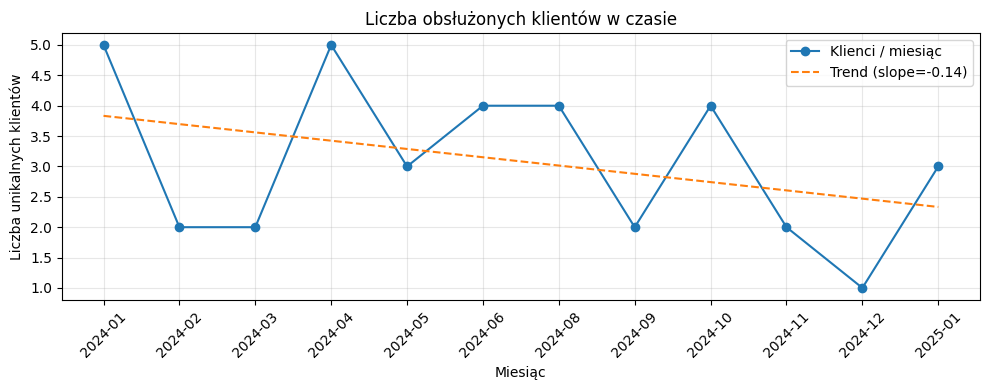

In [47]:
# kolumna data_rezerwacji ma typ DATE/DATETIME → parse_dates
rez = pd.read_sql(
    "SELECT id_klienta, data_rezerwacji FROM Rezerwacje",
    engine,
    parse_dates=['data_rezerwacji']
)

# liczba unikalnych klientów per miesiąc
monthly = (rez
           .assign(month=rez['data_rezerwacji'].dt.to_period('M'))
           .groupby('month')['id_klienta']
           .nunique()
           .rename('klienci')
           .reset_index())

monthly = monthly.sort_values('month')          # chronologicznie
x = np.arange(len(monthly))

# linia trendu (prosta regresja)
coeffs = np.polyfit(x, monthly['klienci'], 1)   # współczynnik kierunkowy = slope
slope  = coeffs[0]
trend  = np.poly1d(coeffs)(x)

# wykres
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(monthly['month'].astype(str), monthly['klienci'],
        marker='o', label='Klienci / miesiąc')
ax.plot(monthly['month'].astype(str), trend,
        linestyle='--', label=f'Trend (slope={slope:.2f})')

ax.set_xlabel('Miesiąc')
ax.set_ylabel('Liczba unikalnych klientów')
ax.set_title('Liczba obsłużonych klientów w czasie')
ax.tick_params(axis='x', rotation=45)
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

max_month_row = pd.read_sql("""
    SELECT DATE_FORMAT(data_rezerwacji, '%%Y-%%m') AS miesiac,
           COUNT(DISTINCT id_klienta) AS unikalni_klienci
    FROM Rezerwacje
    GROUP BY miesiac
    ORDER BY unikalni_klienci DESC
    LIMIT 1;
""", engine)

max_month = max_month_row['miesiac'].iloc[0]

min_month_row = pd.read_sql("""
    SELECT DATE_FORMAT(data_rezerwacji, '%%Y-%%m') AS miesiac,
           COUNT(DISTINCT id_klienta) AS unikalni_klienci
    FROM Rezerwacje
    GROUP BY miesiac
    ORDER BY unikalni_klienci ASC
    LIMIT 1;
""", engine)

min_month = min_month_row['miesiac'].iloc[0]



# # interpretacja
# if slope > 0.2:      # próg >0,2 klienta/miesiąc, aby uniknąć szumu
#     print(f" Firma rośnie – średnio przybywa około {slope:.2f} klienta/miesiąc.")
# elif slope < -0.2:
#     print(f" Firma podupada – średnio traci około {-slope:.2f} klienta/miesiąc.")
# else:
#     print(" Firma utrzymuje w miarę stały poziom obsłużonych klientów.")

In [48]:
display(Markdown(f"#### Największa liczba klientów została odnotowana w **{max_month}**, natomiast najniższa – w **{min_month}**. Współczynnik kierunkowy regresji wynosi **{round(coeffs[0], 2)}** klienta na miesiąc."))

#### Największa liczba klientów została odnotowana w **2024-01**, natomiast najniższa – w **2024-12**. Współczynnik kierunkowy regresji wynosi **-0.14** klienta na miesiąc.

#### Wnioski
Na obecnym etapie działalności firmy nie można mówić ani o jednoznacznym wzroście, ani o gwałtownym spadku zainteresowania usługami. Firma nie wykazuje istotnego przyrostu klientów miesiąc do miesiąca, ale też nie notuje dramatycznego spadku, co może oznaczać stabilizację rynku.

### **Po których wycieczkach klienci wracają na kolejne, a po których mają dość? Czy są takie, które być może powinny zniknąć z oferty?**

Retencja klientów, czyli odsetek osób powracających do ponownego skorzystania z usług, jest jedną z najważniejszych miar satysfakcji i lojalności klientów. Celem niniejszej analizy było zidentyfikowanie, które rodzaje wypraw oferowane przez firmę Space-U skłaniają klientów do powrotu, a które wręcz przeciwnie – mogą ich zniechęcać.

Analizie poddaliśmy dane z tabel Rezerwacje, Wyprawy i Rodzaje_Wypraw. Dla każdego klienta ustaliliśmy chronologię rezerwacji, a następnie oznaczyliśmy, czy po danej wyprawie dokonał kolejnej rezerwacji. Obliczyliśmy retencję (%) jako stosunek liczby klientów powracających po danej wyprawie do ogólnej liczby jej uczestników.

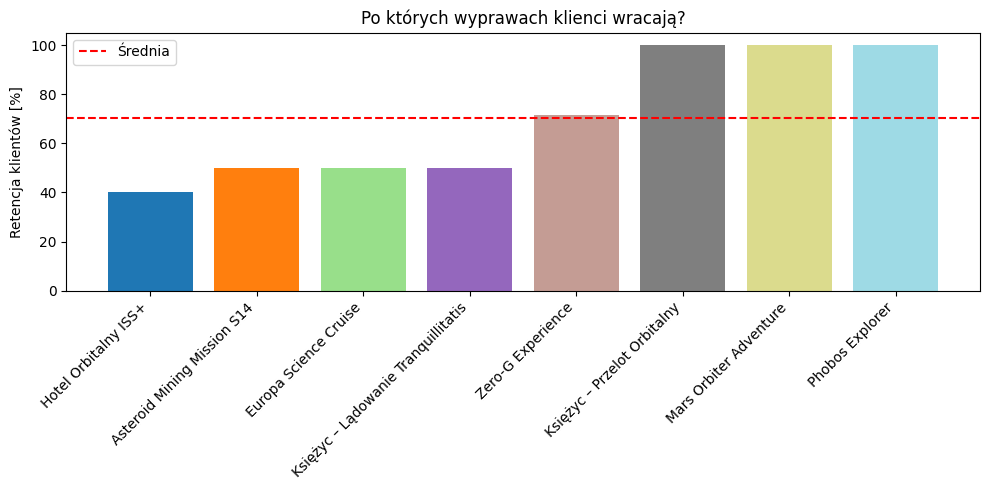


  Retencja klientów (posortowana rosnąco):

                       rodzaj_nazwa  klienci retencja_%
               Hotel Orbitalny ISS+        5       40.0
        Asteroid Mining Mission S14        4       50.0
              Europa Science Cruise        4       50.0
Księżyc – Lądowanie Tranquillitatis        2       50.0
                  Zero-G Experience        7       71.4
        Księżyc – Przelot Orbitalny        6      100.0
             Mars Orbiter Adventure        5      100.0
                    Phobos Explorer        2      100.0

  Kierunki o dosc niskiej retencji (opcje do przemyślenia):
  • Hotel Orbitalny ISS+ → 40.0% powrotów (klienci: 5)


In [49]:
sql = """
SELECT r.id_rezerwacji,
       r.id_klienta,
       r.id_wyprawy,
       r.data_rezerwacji,
       w.id_rodzaju_wyprawy,
       rw.nazwa AS rodzaj_nazwa
FROM   Rezerwacje       r
JOIN   Wyprawy          w  ON w.id_wyprawy = r.id_wyprawy
JOIN   Rodzaje_Wypraw   rw ON rw.id_rodzaju = w.id_rodzaju_wyprawy
"""
rez = pd.read_sql(sql, engine, parse_dates=['data_rezerwacji'])

# czy klient wrócił po danej rezerwacji 
rez = rez.sort_values(['id_klienta', 'data_rezerwacji'])
rez['czy_wrocil'] = rez.groupby('id_klienta')['data_rezerwacji'].shift(-1).notna()

# agregacja unikalnych rezerwacji
unikalne = rez.drop_duplicates(['id_klienta', 'id_wyprawy'])

ret = (unikalne
       .groupby('rodzaj_nazwa', as_index=False)
       .agg(klienci=('id_klienta', 'size'),
            powroty=('czy_wrocil', 'sum')))

ret['retencja_%'] = 100 * ret['powroty'] / ret['klienci']
ret = ret.sort_values('retencja_%')

# wykres 
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(ret['rodzaj_nazwa'], ret['retencja_%'],
              color=plt.cm.tab20(np.linspace(0, 1, len(ret))))

ax.set_ylabel('Retencja klientów [%]')
ax.set_title('Po których wyprawach klienci wracają?')
ax.axhline(ret['retencja_%'].mean(), color='red', linestyle='--', label='Średnia')

ax.set_xticks(np.arange(len(ret)))
ax.set_xticklabels(ret['rodzaj_nazwa'], rotation=45, ha='right')

ax.legend()
plt.tight_layout()
plt.show()

# interpretacja
avg = ret['retencja_%'].mean()
slabe = ret[ret['retencja_%'] < avg * 0.7]   # <70% średniej

print("\n  Retencja klientów (posortowana rosnąco):\n")
print(ret[['rodzaj_nazwa','klienci','retencja_%']].to_string(index=False, 
      formatters={'retencja_%':'{:,.1f}'.format}))

if slabe.empty:
    print("\n  Żaden rodzaj wyprawy nie odstaje dramatycznie poniżej średniej.")
else:
    print("\n  Kierunki o dosc niskiej retencji (opcje do przemyślenia):")
    for _, row in slabe.iterrows():
        print(f"  • {row['rodzaj_nazwa']} → {row['retencja_%']:.1f}% powrotów "
              f"(klienci: {row['klienci']})")


In [50]:
display(Markdown(f"#### Średnia retencja dla wszystkich wypraw wyniosła około {round(ret['retencja_%'].mean(), 2)}%."))

#### Średnia retencja dla wszystkich wypraw wyniosła około 70.18%.

#### Wnioski
Retencja klientów jest zróżnicowana i zależna od konkretnego typu wyprawy.

Wyprawy o retencji znacznie poniżej średniej (<50%) powinny zostać dokładnie przeanalizowane – być może wymagają zmiany scenariusza, lepszej obsługi lub wycofania z oferty.

### **Czy wyższa cena bazowa wyprawy koreluje z niższą popularnością?**

Ważnym aspektem strategii produktowej firmy Space-U jest zrozumienie zależności między ceną wyprawy a zainteresowaniem klientów. Celem tej analizy było sprawdzenie, czy wyprawy o wyższej cenie bazowej są mniej popularne, co mogłoby sugerować potrzebę optymalizacji polityki cenowej.

Analizie poddaliśmy dane dotyczące ceny bazowej wyprawy (cena_bazowa) z tabeli Rodzaje_Wypraw oraz liczby rezerwacji dla każdego rodzaju wyprawy.

Dla każdej wyprawy obliczyliśmy liczbę dokonanych rezerwacji i zestawiliśmy ją z ceną bazową. Następnie wyznaczyliśmy współczynnik korelacji Pearsona między tymi zmiennymi.

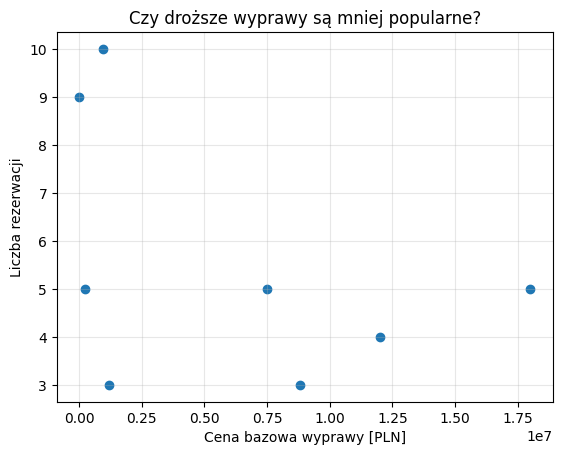

In [51]:
base = pd.read_sql("SELECT id_rodzaju, cena_bazowa FROM Rodzaje_Wypraw", engine)
merged = by_type.merge(base, on='id_rodzaju')

corr = merged['rezerwacje'].corr(merged['cena_bazowa'])
plt.scatter(merged['cena_bazowa'], merged['rezerwacje'])
plt.xlabel("Cena bazowa wyprawy [PLN]")
plt.ylabel("Liczba rezerwacji")
plt.title("Czy droższe wyprawy są mniej popularne?")
plt.grid(alpha=0.3)
plt.show()


In [52]:
display(Markdown(f"#### Współczynnik korelacji wyniósł {round(corr,2)}."))

#### Współczynnik korelacji wyniósł -0.42.

#### Wnioski
Cena bazowa ma wpływ na decyzje klientów. Firma powinna zachować zróżnicowaną ofertę cenową, dostosowaną do różnych segmentów klientów. Warto zaznaczyć wartość i jakość wypraw premium, by uzasadnić ich cenę i utrzymać ich rentowność mimo mniejszej liczby uczestników.

### **Które wyprawy są najczęściej wybierane przez klientów o stanie zdrowia "zły"?**

W branży turystyki kosmicznej bezpieczeństwo i dostępność dla osób w różnym stanie zdrowia to ważny aspekt oferty. Celem tej analizy było sprawdzenie, które wyprawy najczęściej wybierają klienci, którzy podczas rezerwacji zgłosili stan zdrowia jako „zły”.

Analizie poddaliśmy dane z tabel Rezerwacje, Klienci, Wyprawy i Rodzaje_Wypraw. Wyselekcjonowaliśmy rezerwacje dokonane przez osoby ze stanem zdrowia określonym jako „zły”. Następnie pogrupowaliśmy te rezerwacje według rodzaju wyprawy i policzyliśmy ich liczbę.


Najpopularniejsze rodzaje wypraw wśród klientów o stanie zdrowia 'zły':
               rodzaj_nazwa  rezerwacje_slabsi
      Europa Science Cruise                  4
Księżyc – Przelot Orbitalny                  3
Asteroid Mining Mission S14                  2
       Hotel Orbitalny ISS+                  2
     Mars Orbiter Adventure                  1


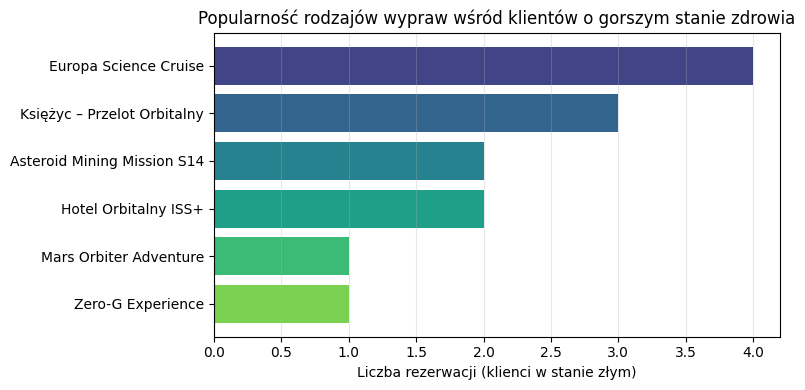

In [53]:
sql = """
SELECT r.id_rezerwacji, r.id_wyprawy, k.wyniki_badan,
       w.id_rodzaju_wyprawy, rw.nazwa AS rodzaj_nazwa
FROM   Rezerwacje r
JOIN   Klienci    k  ON r.id_klienta = k.id_klienta
JOIN   Wyprawy    w  ON r.id_wyprawy = w.id_wyprawy
JOIN   Rodzaje_Wypraw rw ON rw.id_rodzaju = w.id_rodzaju_wyprawy
"""
dane = pd.read_sql(sql, engine)

# filtrowanie na osoby w stanie  „zły”
slabsi = dane[dane['wyniki_badan'].isin(['zły'])]

# grupowanie po nazwie wyprawy
slabsi_top = (slabsi.groupby('rodzaj_nazwa', as_index=False)
                     .size()
                     .rename(columns={'size': 'rezerwacje_slabsi'})
                     .sort_values('rezerwacje_slabsi', ascending=False))

print("\nNajpopularniejsze rodzaje wypraw wśród klientów o stanie zdrowia 'zły':")
print(slabsi_top.head(5).to_string(index=False))

# wykres
fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.barh(slabsi_top['rodzaj_nazwa'], slabsi_top['rezerwacje_slabsi'],
               color=plt.cm.viridis(np.linspace(0.2, 0.8, len(slabsi_top))))

ax.set_xlabel('Liczba rezerwacji (klienci w stanie złym)')
ax.set_title("Popularność rodzajów wypraw wśród klientów o gorszym stanie zdrowia")
ax.invert_yaxis()  # najwyższe na górze
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

najczestsze_slabsi_row = pd.read_sql("""
    SELECT rw.nazwa AS rodzaj_wyprawy,
           COUNT(*) AS liczba_rezerwacji
    FROM Rezerwacje r
    JOIN Klienci k          ON r.id_klienta = k.id_klienta
    JOIN Wyprawy w          ON r.id_wyprawy = w.id_wyprawy
    JOIN Rodzaje_Wypraw rw  ON w.id_rodzaju_wyprawy = rw.id_rodzaju
    WHERE k.wyniki_badan IN ('średni', 'zły')
    GROUP BY rw.id_rodzaju, rw.nazwa
    ORDER BY liczba_rezerwacji DESC
    LIMIT 1;
""", engine)

najczestsza_slabsi = najczestsze_slabsi_row['rodzaj_wyprawy'].iloc[0]


In [54]:
display(Markdown(f"#### Wyniki wskazują, że najczęściej wybieraną opcją był **{najczestsza_slabsi}**, co może sugerować jego postrzeganie jako wyprawy niewymagającej dużego wysiłku fizycznego. Inne popularne w tej grupie wyprawy również mogą być odbierane jako mniej wymagające."))



#### Wyniki wskazują, że najczęściej wybieraną opcją był **Europa Science Cruise**, co może sugerować jego postrzeganie jako wyprawy niewymagającej dużego wysiłku fizycznego. Inne popularne w tej grupie wyprawy również mogą być odbierane jako mniej wymagające.

#### Wnioski
Warto zidentyfikować i wyróżnić w ofercie wyprawy dedykowane klientom o ograniczonej sprawności.

Możemy rozważyć stworzenie specjalnych programów dostosowanych do tej grupy – z uproszczoną procedurą medyczną, skróconym czasem wyprawy, opieką medyczną na pokładzie.


### Jakie metody płatności są najczęściej wybierane?

Wybór metody płatności to istotny element procesu zakupowego, który wpływa na wygodę klienta i jego skłonność do finalizacji transakcji. Celem tej analizy było zidentyfikowanie najczęściej wykorzystywanych form płatności za wyprawy kosmiczne.

Z analizy pola metoda_platnosci w tabeli Rezerwacje obliczyliśmy liczbę rezerwacji zrealizowanych przy użyciu każdej z metod płatności. Wyniki przedstawiliśmy w formie wykresu słupkowego.

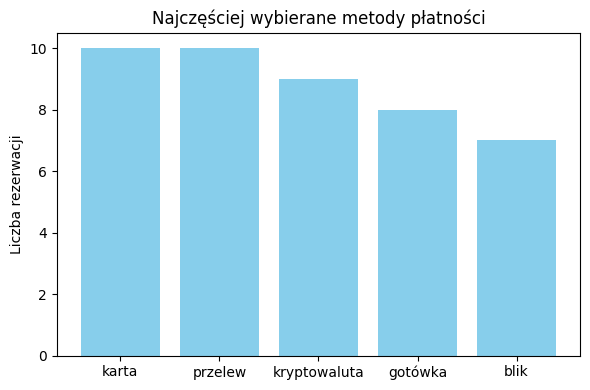

In [55]:
sql = "SELECT metoda_platnosci FROM Rezerwacje"
metody = pd.read_sql(sql, engine)

count = metody.value_counts('metoda_platnosci').reset_index(name='liczba')

# wykres
plt.figure(figsize=(6,4))
plt.bar(count['metoda_platnosci'], count['liczba'], color='skyblue')
plt.title("Najczęściej wybierane metody płatności")
plt.ylabel("Liczba rezerwacji")
plt.tight_layout()
plt.show()

najczestsza_metoda_row = pd.read_sql("""
    SELECT metoda_platnosci, COUNT(*) AS liczba
    FROM Rezerwacje
    GROUP BY metoda_platnosci
    ORDER BY liczba DESC
    LIMIT 1;
""", engine)

najczestsza_metoda = najczestsza_metoda_row['metoda_platnosci'].iloc[0]


In [56]:
display(Markdown(f"#### Najczęściej wybierana metoda płatności to **{najczestsza_metoda}**."))

#### Najczęściej wybierana metoda płatności to **karta**.

### **Jak wyniki badań rzutują na uczestnictwo w kolejnych wyprawach?**

Zbadaliśmy, czy wyniki badań klientów mają wpływ na ich skłonność do powrotu i uczestnictwa w kolejnych wyprawach organizowanych przez firmę Space-U. Interesowało nas, czy osoby z lepszymi wynikami częściej wracają.

Połączyliśmy dane z tabel Rezerwacje i Klienci, grupując rezerwacje według klienta oraz porządkując je chronologicznie. Sprawdziliśmy, czy po pierwszej rezerwacji klient dokonał kolejnej. Następnie podzieliliśmy klientów według ich wyników badań („dobry”, „zły”, „fatalny") i policzyliśmy, jaki odsetek z każdej grupy wrócił na kolejną wyprawę.

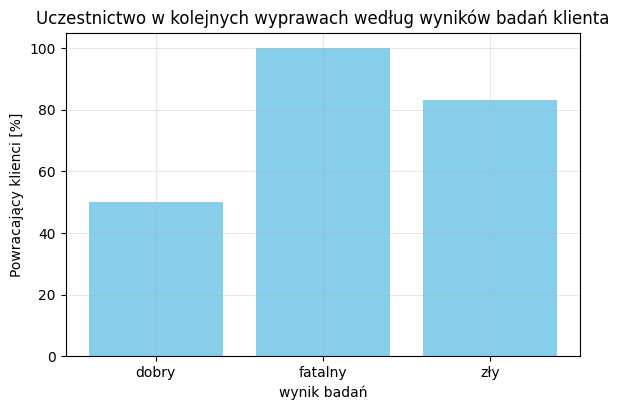

In [57]:
sql = """
SELECT r.id_klienta, r.data_rezerwacji, k.wyniki_badan
FROM Rezerwacje r
JOIN Klienci k ON r.id_klienta = k.id_klienta
"""
zdrowie = pd.read_sql(sql, engine, parse_dates=['data_rezerwacji'])
zdrowie = zdrowie.sort_values(['id_klienta', 'data_rezerwacji'])

zdrowie['czy_wrocil'] = zdrowie.groupby('id_klienta')['data_rezerwacji'].shift(-1).notna()

ret_zdrowie = (zdrowie
               .drop_duplicates('id_klienta')
               .groupby('wyniki_badan', as_index=False)
               .agg(klienci=('id_klienta','size'),
                    powroty=('czy_wrocil','sum')))

ret_zdrowie['retencja_%'] = 100 * ret_zdrowie['powroty'] / ret_zdrowie['klienci']

# wykres
plt.figure(figsize=(6,4))
plt.bar(ret_zdrowie['wyniki_badan'], ret_zdrowie['retencja_%'], color='skyblue')
plt.ylabel("Powracający klienci [%]")
plt.title("Uczestnictwo w kolejnych wyprawach według wyników badań klienta")
plt.tight_layout()
plt.xlabel("wynik badań")
plt.grid(alpha=0.3)
plt.show()


In [58]:
wniosek_retencja = ""

for _, row in ret_zdrowie.iterrows():
    stan = row['wyniki_badan']
    ret = row['retencja_%']
    
    if ret >= 70:
        ocena = "bardzo wysoką"
        komentarz = "świadczy o zadowoleniu z usług."
    elif ret >= 40:
        ocena = "umiarkowaną"
        komentarz = "może oznaczać, że należy poprawić usługi."
    else:
        ocena = "niską"
        komentarz = "może sugerować poważne problemy dla firmy."

    wniosek_retencja += f"- Dla wyniku **{stan}**, retencja wynosi **{ret:.1f}%**, co oznacza {ocena} chęć powrotu klientów, {komentarz}\n"

display(Markdown("#### Wnioski dotyczące wyników badań i retencji:\n" + wniosek_retencja))


#### Wnioski dotyczące wyników badań i retencji:
- Dla wyniku **dobry**, retencja wynosi **50.0%**, co oznacza umiarkowaną chęć powrotu klientów, może oznaczać, że należy poprawić usługi.
- Dla wyniku **fatalny**, retencja wynosi **100.0%**, co oznacza bardzo wysoką chęć powrotu klientów, świadczy o zadowoleniu z usług.
- Dla wyniku **zły**, retencja wynosi **83.3%**, co oznacza bardzo wysoką chęć powrotu klientów, świadczy o zadowoleniu z usług.


### **Które wyprawy są najczęściej polecane przez klientów?**

Celem tej analizy było zidentyfikowanie, które rodzaje wypraw kosmicznych są najczęściej polecane przez klientów oraz zbadanie, czy wysoka ocena wyprawy wiąże się z większą skłonnością do jej polecenia. Analiza została przeprowadzona w oparciu o dane dotyczące ocen oraz czy_poleca, które informuje, czy klient zarekomendowałby wyprawę innym.


  Współczynnik poleceń wg rodzaju wyprawy:

                              nazwa poziom_trudnosci  liczba_ocen  srednia_ocena polecenia_rate
              Europa Science Cruise      ekstremalny            4           4.50         100.0%
               Hotel Orbitalny ISS+      umiarkowany            5           4.40         100.0%
Księżyc – Lądowanie Tranquillitatis           trudny            2           5.00         100.0%
        Księżyc – Przelot Orbitalny      umiarkowany            6           4.17         100.0%
                    Phobos Explorer      ekstremalny            2           5.00         100.0%
             Mars Orbiter Adventure           trudny            5           4.40         100.0%
                  Zero-G Experience            łatwy            7           4.43          85.7%
        Asteroid Mining Mission S14      ekstremalny            4           4.50          75.0%


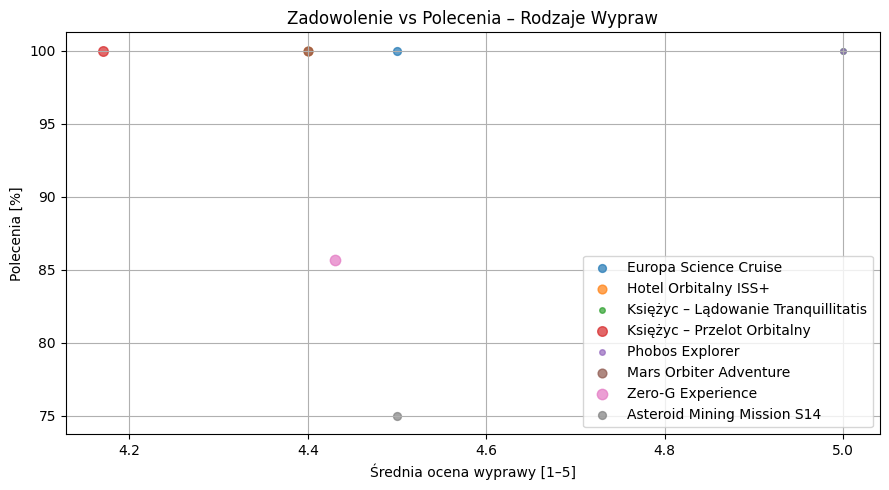

In [59]:

rodzaje = pd.read_sql("""
    SELECT id_rodzaju, nazwa, czas_trwania_dni, cena_bazowa, poziom_trudnosci 
    FROM Rodzaje_Wypraw
""", engine)

wyprawy = pd.read_sql("SELECT id_wyprawy, id_rodzaju_wyprawy FROM Wyprawy", engine)

oceny = pd.read_sql("""
    SELECT id_wyprawy, ocena, czy_poleca
    FROM Opinie_Klientow
""", engine)


df = (
    oceny
    .merge(wyprawy, on='id_wyprawy')
    .merge(rodzaje, left_on='id_rodzaju_wyprawy', right_on='id_rodzaju')
)


df['czy_poleca'] = pd.to_numeric(df['czy_poleca'], errors='coerce')
df['ocena'] = pd.to_numeric(df['ocena'], errors='coerce')


by_type = (
    df.groupby(['nazwa', 'poziom_trudnosci'], as_index=False)
    .agg(
        liczba_ocen=('ocena', 'size'),
        srednia_ocena=('ocena', 'mean'),
        polecenia_rate=('czy_poleca', 'mean'),
        srednia_cena=('cena_bazowa', 'mean'),
        sredni_czas=('czas_trwania_dni', 'mean')
    )
)


by_type['polecenia_rate'] = (by_type['polecenia_rate'] * 100).round(1)  
by_type['srednia_ocena'] = by_type['srednia_ocena'].round(2)


by_type = by_type.sort_values('polecenia_rate', ascending=False)


print("\n  Współczynnik poleceń wg rodzaju wyprawy:\n")
print(by_type[['nazwa', 'poziom_trudnosci', 'liczba_ocen', 'srednia_ocena', 'polecenia_rate']]
      .to_string(index=False, formatters={'polecenia_rate': '{:.1f}%'.format}))


fig, ax = plt.subplots(figsize=(9, 5))


colors = {'łatwa': 'green', 'średnia': 'orange', 'trudna': 'red'}

for _, row in by_type.iterrows():
    ax.scatter(row['srednia_ocena'], row['polecenia_rate'],
               s=row['liczba_ocen'] * 8,
               color=colors.get(row['poziom_trudnosci']),
               alpha=0.7,
               label=row['nazwa'])

ax.set_xlabel("Średnia ocena wyprawy [1–5]")
ax.set_ylabel("Polecenia [%]")
ax.set_title("Zadowolenie vs Polecenia – Rodzaje Wypraw")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

najwyzsza_ocena_row = pd.read_sql("""
    SELECT rw.nazwa, rw.poziom_trudnosci, AVG(ok.ocena) AS srednia_ocena
    FROM Opinie_Klientow ok
    JOIN Wyprawy w ON ok.id_wyprawy = w.id_wyprawy
    JOIN Rodzaje_Wypraw rw ON w.id_rodzaju_wyprawy = rw.id_rodzaju
    GROUP BY rw.nazwa, rw.poziom_trudnosci
    ORDER BY srednia_ocena DESC
    LIMIT 1;
""", engine)

najwyzsza_ocena_nazwa = najwyzsza_ocena_row['nazwa'].iloc[0]
najwyzsza_ocena_wartosc = najwyzsza_ocena_row['srednia_ocena'].iloc[0]

najwyzszy_polecenia_row = pd.read_sql("""
    SELECT rw.nazwa, rw.poziom_trudnosci, 
           100.0 * AVG(ok.czy_poleca) AS polecenia_procent
    FROM Opinie_Klientow ok
    JOIN Wyprawy w ON ok.id_wyprawy = w.id_wyprawy
    JOIN Rodzaje_Wypraw rw ON w.id_rodzaju_wyprawy = rw.id_rodzaju
    GROUP BY rw.nazwa, rw.poziom_trudnosci
    ORDER BY polecenia_procent DESC
    LIMIT 1;
""", engine)

najwyzszy_polecenia_nazwa = najwyzszy_polecenia_row['nazwa'].iloc[0]
najwyzszy_polecenia_wartosc = najwyzszy_polecenia_row['polecenia_procent'].iloc[0]




In [60]:
display(Markdown(f"#### Najwyżej oceniana wyprawa to **{najwyzsza_ocena_nazwa}**, która uzyskała średnią ocenę **{najwyzsza_ocena_wartosc}**. Oznacza to, że wszyscy klienci biorący udział w tej wyprawie byli w usatysfakcjonowani z doświadczenia i ocenili je bardzo wysoko. Najchętniej polecana wyprawa to **{najwyzszy_polecenia_nazwa}**, która osiągnęła **{najwyzszy_polecenia_wartosc}** % współczynnik poleceń – uczestnicy zadeklarowali, że poleciliby ją innym. To świadczy o wyjątkowej jakości i atrakcyjności tej oferty."))



#### Najwyżej oceniana wyprawa to **Phobos Explorer**, która uzyskała średnią ocenę **5.0**. Oznacza to, że wszyscy klienci biorący udział w tej wyprawie byli w usatysfakcjonowani z doświadczenia i ocenili je bardzo wysoko. Najchętniej polecana wyprawa to **Europa Science Cruise**, która osiągnęła **100.0** % współczynnik poleceń – uczestnicy zadeklarowali, że poleciliby ją innym. To świadczy o wyjątkowej jakości i atrakcyjności tej oferty.

In [61]:
# Generowanie raportu html

def remove_converter_logs(html_body):
    """
    Usuwa z HTML-a wszystkie elementy zawierające tekst '[NbConvertApp]'.
    """
    soup = BeautifulSoup(html_body, 'html.parser')
    # Usuwamy wszystkie elementy, których tekst zawiera wzorzec loga
    for tag in soup.find_all(string=lambda text: text and "[NbConvertApp]" in text):
        parent = tag.parent
        if parent:
            parent.decompose()
    return str(soup)

def convert_notebook_to_html(input_path, output_path):
    # Wyciszamy logi
    logging.getLogger().setLevel(logging.ERROR)
    logging.getLogger('nbconvert').setLevel(logging.ERROR)
    logging.getLogger('NbConvertApp').setLevel(logging.ERROR)
    sys.tracebacklimit = 0

    # Wczytanie notebooka z odpowiednim kodowaniem
    with open(input_path, encoding="utf-8") as f:
        nb = nbformat.read(f, as_version=4)

    # Konfiguracja eksportera: wyłączenie wyświetlania komórek z kodem
    c = Config()
    c.HTMLExporter.exclude_input = True
    c.HTMLExporter.exclude_input_prompt = True
    exporter = HTMLExporter(config=c)

    # Uruchamiamy konwersję przekierowując stdout i stderr do devnull
    with open(os.devnull, 'w') as devnull:
        with contextlib.redirect_stdout(devnull), contextlib.redirect_stderr(devnull):
            body, _ = exporter.from_notebook_node(nb)

    # Dodaj meta charset, aby mieć pewność, że polskie znaki będą wyświetlane prawidłowo.
    body = body.replace("<head>", "<head>\n<meta charset='utf-8'>")

    # Usuń ewentualne logi nbconvert z wygenerowanego HTML-a
    body = remove_converter_logs(body)

    # Zapisujemy wynik do pliku
    with open(output_path, "w", encoding="utf-8") as f:
        f.write(body)

convert_notebook_to_html("analiza_bazy_danych1.ipynb", "raport.html")